# Data Leakage

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer

## Learning Goals

- avoid letting information about test sets get into the training of models
- understand train-test split
- use best practices for building non-leaky workflows
- repair leaky workflows

## Train Test Split

We have encountered the idea of splitting our data into two, *training* our model on one bit and then *testing* it on the other.

The goal is to have an unbiased assessment of our model, and so we want to make sure that nothing about our test data sneaks into the training run of the model.

![](./images/ttsplit.png)

modified from [sklearn](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

Why do we split?

We need to test our model on unseen data to properly gauge how well the model predicts.

This is done by taking a subset of our data (usually in the 15%-20% range) and setting it aside.

This [blog](https://github.com/learn-co-curriculum/dsc-log-transformations-lab.git) post does an excellent job of laying out more of the reasons why.

The model is trained on the "training" data that remains. 

There is, of course, the sci-kit learn method: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

So now, your modeling process looks like this:

1. Get Data
2. EDA
3. Cleaning
4. Feature Engineering
5. Train/Test split
6. Model training using `train` split
7. Model testing using `test` split

If, after looking at the model results, you decide to do more feature engineering, or, really, ANYTHING at all to the data, return to step 5 and redo the Train/Test split. This ensures model integrity and helps to prevent data leakage, which is something we'll discuss later.

## A Mistake

Now consider the following workflow:

In [2]:
data = load_diabetes()

print(data.DESCR)

df = pd.concat([pd.DataFrame(data.data, columns=data.feature_names),
               pd.Series(data.target, name='target')], axis=1)

df.head()

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
len(X)

442

Scale and run a regression


In [5]:
# Code

ss = StandardScaler()

In [6]:
ss.fit(X)

StandardScaler()

In [7]:
X_scaled = ss.transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)

In [9]:
len(X_train)

331

In [10]:
len(X_test)

111

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.coef_, lr.intercept_)

[  2.27122069 -11.51033366  25.30328309  18.14909453 -43.68872789
  24.17535737   5.56275205  12.81844165  33.09621706   1.25213268] 151.66517559199326


Well we fit the model only to our training data. Looks like we've done everything right, right?

It's important to understand that the answer here is a resounding "NO". It's true that we didn't directly fit our model to our test data. But the trouble is that we fit our scaler **to the whole dataset**. That is, records in the test data are contributing to calculations of column means and standard deviations, and so, surreptitiously, information about our test set is sneaking into the training run of the model after all!

To correct our mistake, we'll make sure to perform our train-test split **first**:

In [12]:
# Code
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=42)

ss2 = StandardScaler()
ss2.fit(X_train2)
X_train2_scaled = ss2.transform(X_train2)
lr2 = LinearRegression()
lr2.fit(X_train2_scaled, y_train2)
print(lr2.coef_, lr2.intercept_)
print(lr2.score(X_train2_scaled, y_train))

[  2.21507746 -11.51448208  25.07696866  18.24929273 -44.14464184
  24.51385277   5.49759327  13.00675611  33.37981899   1.2479725 ] 154.34441087613294
0.519034189167905


In [13]:
X_test2_scaled = ss2.transform(X_test2)

lr2.score(X_test2_scaled, y_test2)

0.4849058889476754

Note that our model coefficients are slightly different from what they were before.

### Error Comparison

It's worth pointing out that, **for linear models**, there is **no** difference in modeling error:

In [14]:
y_test_hat = lr.predict(X_test)
mse = mean_squared_error(y_test, y_test_hat)
print(f"Our test RMSE for this model is {round(np.sqrt(mse), 5)}.")

Our test RMSE for this model is 53.36957.


In [15]:
y_test2_hat = lr2.predict(X_test2_scaled)
mse = mean_squared_error(y_test2, y_test2_hat)
print(f"Our test RMSE for this model is {round(np.sqrt(mse), 5)}.")

Our test RMSE for this model is 53.36957.


This will **not** be true for other sorts of models that use different loss functions.

## Preprocessing

In general all preprocessing steps are subject to the same dangers here. Consider the preprocessing step of one-hot-encoding:

In [16]:
gun_poll = pd.read_csv('data/guns-polls.csv')

In [17]:
gun_poll.head()

,Question,Start,End,Pollster,Population,Support,Republican Support,Democratic Support,URL
0,age-21,2/20/18,2/23/18,CNN/SSRS,Registered Voters,72,61,86,http://cdn.cnn.com/cnn/2018/images/02/25/rel3a...
1,age-21,2/27/18,2/28/18,NPR/Ipsos,Adults,82,72,92,https://www.ipsos.com/en-us/npripsos-poll-majo...
2,age-21,3/1/18,3/4/18,Rasmussen,Adults,67,59,76,http://www.rasmussenreports.com/public_content...
3,age-21,2/22/18,2/26/18,Harris Interactive,Registered Voters,84,77,92,http://thehill.com/opinion/civil-rights/375993...
4,age-21,3/3/18,3/5/18,Quinnipiac,Registered Voters,78,63,93,https://poll.qu.edu/national/release-detail?Re...


In [18]:
gun_poll['Pollster'].value_counts()

YouGov                 12
Morning Consult        11
Quinnipiac              8
NPR/Ipsos               7
CNN/SSRS                5
CBS News                4
Rasmussen               2
Suffolk                 2
Harris Interactive      1
YouGov/Huffpost         1
SurveyMonkey            1
ABC/Washington Post     1
Harvard/Harris          1
Marist                  1
Name: Pollster, dtype: int64

Now if I were to fit a one-hot encoder to the whole `Pollster` column here, the encoder would learn all the categories. But I need to prepare myself for the real-world possibility that unfamiliar categories may show up in future records. Let's explore this.

In [19]:
# First I'll do a split
X_train, X_test = train_test_split(gun_poll, random_state=42)

Let's suppose now that I fit a `OneHotEncoder` to the `Pollster` column in my training data.

#### Exercise

Fit an encoder to the `Pollster` column of the training data and then check to see which categories are represented.

In [20]:
# Code

to_be_dummied = X_train[['Pollster']]

In [21]:
ohe= OneHotEncoder()

In [22]:
ohe.fit(to_be_dummied)

OneHotEncoder()

In [23]:
ohe.get_feature_names_out()

array(['Pollster_ABC/Washington Post', 'Pollster_CBS News',
       'Pollster_CNN/SSRS', 'Pollster_Marist', 'Pollster_Morning Consult',
       'Pollster_NPR/Ipsos', 'Pollster_Quinnipiac', 'Pollster_Rasmussen',
       'Pollster_Suffolk', 'Pollster_YouGov', 'Pollster_YouGov/Huffpost'],
      dtype=object)

In [24]:
# So what categories do we have?

We'll want to transform both train and test after we've fitted the encoder to the train.

In [25]:
test_to_be_dummied = X_test[['Pollster']]

ohe.transform(to_be_dummied)
ohe.transform(test_to_be_dummied)

ValueError: Found unknown categories ['Harvard/Harris', 'SurveyMonkey', 'Harris Interactive'] in column 0 during transform

In [26]:
test_to_be_dummied.value_counts()

Pollster          
YouGov                3
CBS News              2
CNN/SSRS              2
Morning Consult       2
Quinnipiac            2
Harris Interactive    1
Harvard/Harris        1
NPR/Ipsos             1
SurveyMonkey          1
dtype: int64

In [27]:
to_be_dummied.value_counts()

Pollster           
Morning Consult        9
YouGov                 9
NPR/Ipsos              6
Quinnipiac             6
CNN/SSRS               3
CBS News               2
Rasmussen              2
Suffolk                2
ABC/Washington Post    1
Marist                 1
YouGov/Huffpost        1
dtype: int64

There are categories in the testing data that don't appear in the training data! What should 
we do about that?

### Approaches

- **Strategy 1**: Divide up the categories proportionally when we do our train_test_split. If we're using `sklearn`'s tool, that means taking advantage of the `stratify` parameter:

In [28]:
new_X_train, new_X_test = train_test_split(gun_poll,
                                           stratify=gun_poll['Pollster'],
                                           random_state=42)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Unfortunately, in this case, we can't use this since some categories have only a single member.

- **Strategy 2**: Drop the categories with very few representatives.

In the present case, let's try dropping the single-member categories.

In [29]:
# Code

vc = gun_poll['Pollster'].value_counts()

vc_only1 = vc[   vc==1 ]

bad_cols = vc_only1.index

In [30]:
bad_cols

Index(['Harris Interactive', 'YouGov/Huffpost', 'SurveyMonkey',
       'ABC/Washington Post', 'Harvard/Harris', 'Marist'],
      dtype='object')

In [31]:
# Remove bad columns

gun_poll['Pollster'] = gun_poll['Pollster'].map(lambda x: np.nan if x in bad_cols else x)

In [32]:
gun_poll.dropna(inplace=True)

In [33]:
# Sniff test!
gun_poll['Pollster'].value_counts()

YouGov             12
Morning Consult    11
Quinnipiac          8
NPR/Ipsos           7
CNN/SSRS            5
CBS News            4
Rasmussen           2
Suffolk             2
Name: Pollster, dtype: int64

We could now split this carefully so that new categories don't show up in the testing data. In fact, now we can try the stratified split:

In [34]:
X_train3, X_test3 = train_test_split(gun_poll,
                                     stratify=gun_poll['Pollster'],
                                     test_size=0.3,
                                     random_state=42)

In [35]:
# Sniff Test

X_train3.Pollster.value_counts()

Morning Consult    8
YouGov             8
Quinnipiac         6
NPR/Ipsos          5
CNN/SSRS           3
CBS News           3
Rasmussen          1
Suffolk            1
Name: Pollster, dtype: int64

In [36]:
X_test3.Pollster.value_counts()

YouGov             4
Morning Consult    3
CNN/SSRS           2
Quinnipiac         2
NPR/Ipsos          2
CBS News           1
Rasmussen          1
Suffolk            1
Name: Pollster, dtype: int64

Now every category that appears in the test data appears also in the training data.

- **Strategy 3**: Adjust the settings on the one-hot-encoder.

For `sklearn`'s tool, we'll tweak the `handle_unknown` parameter:

#### Exericse

Fit a new encoder to our training data column that won't break when we try to use it to transform the test data. And then use the encoder to transform both train and test.

In [37]:
gun_poll.sample()

,Question,Start,End,Pollster,Population,Support,Republican Support,Democratic Support,URL
4,age-21,3/3/18,3/5/18,Quinnipiac,Registered Voters,78,63,93,https://poll.qu.edu/national/release-detail?Re...


In [38]:
ohe2 = OneHotEncoder(handle_unknown='ignore')
ohe2.fit(to_be_dummied)
test_to_be_dummied = X_test[['Pollster']]
ohe2.transform(to_be_dummied)
ohe2.transform(test_to_be_dummied)

<15x11 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

## Leakage into Validation Data

If we employ cross-validation, then our training data points will be serving both for training and for validation. So there's a sense in which we can't help but let some information about our validation data sneak into the model.

But strictly speaking, cross-validation means building *multiple* models, and we still want each to be blind to its validation set.

The dangers of data leakage, therefore, are still very much real in the case of validation data. And they are often more subtle as well. Consider the following line of code:

In [39]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

In [40]:
# Using our scaled training data

cv_results = cross_validate(estimator=LinearRegression(),
                X=X_train2_scaled,
                y=y_train2,
                scoring=mse,
                return_estimator=True)

In [41]:
# Looking at model coefficients on the first predictor

[model.coef_[0] for model in cv_results['estimator']]

[0.7682186048687905,
 -0.052900468470024595,
 2.5203131885676293,
 3.724782922229309,
 4.554217346566092]

We've built five models here, and none of them saw any points from the test data, so we have no leaks, right?

Wrong! We fit the `StandardScaler` to the whole training set, which means that information about *every* fold will affect every cross-validation. A better practice here would be to split our data into its cross-validation folds *first*. Then we can fit the scaler to only the training folds for each cross-validation.

Of course, the more preprocessing steps we have, the more tedious it becomes to do this work! For such tasks it is often greatly beneficial to take advantage of `sklearn`'s `Pipeline`s, which we'll have more to say about later.

For now, let's see if we can fix our leaky cross-validation scorer.

#### Exercise

In [42]:
# Code
for train_ind, val_ind in KFold().split(X_train2):
    
    train = X_train2[train_ind, :]
    val = X_train2[val_ind, :]
    
    target_train = y_train2[train_ind]
    target_val = y_train2[val_ind]
    
    ss = StandardScaler().fit(train)
    
    train_scld = ss.transform(train)
    
    val_scld = ss.transform(val)
    
    lr = LinearRegression().fit(train_scld, target_train)
    
    print(lr.coef_[0])

0.7806952540938128
-0.05249497410098458
2.438202921083258
3.7975972324372194
4.560642400525137


In [43]:
[model.coef_[0] for model in cv_results['estimator']]

[0.7682186048687905,
 -0.052900468470024595,
 2.5203131885676293,
 3.724782922229309,
 4.554217346566092]

### A Contrived But Illustrative Example

This is only a slight difference in coefficients, but for other datasets the difference can be great.

In [44]:
fake_preds = np.array([6, 5, 2, 250, 300]).reshape(-1, 1)
fake_target = np.array([25, 30, 12, 400, 420]).reshape(-1, 1)

In [45]:
df = pd.DataFrame(np.hstack((fake_preds, fake_target)),
                 columns=['pred', 'target'])

In [46]:
df

,pred,target
0,6,25
1,5,30
2,2,12
3,250,400
4,300,420


In [47]:
small_train = df[['pred']][:3]
small_val = df[['pred']][3:]
small_train_y = df['target'][:3]
small_val_y = df['target'][3:]

In [48]:
# Scaling the whole dataset

ss = StandardScaler().fit(df[['pred']])

In [49]:
X_tr = ss.transform(small_train)
X_va = ss.transform(small_val)

In [50]:
lr = LinearRegression().fit(X_tr, small_train_y)
lr.coef_

array([518.77056848])

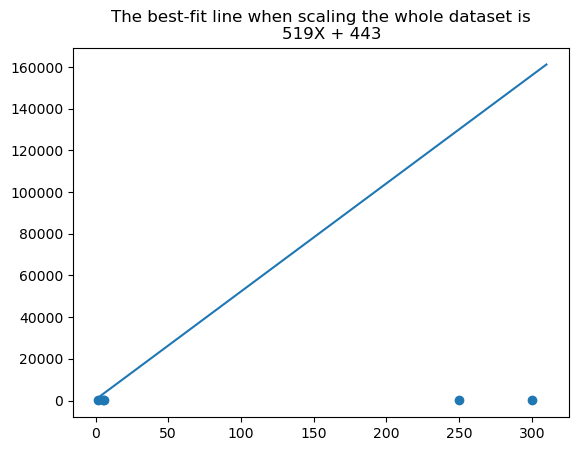

In [51]:
fig, ax = plt.subplots()

X = np.linspace(0, 310, 600)
y = lr.coef_ * X + lr.intercept_

ax.scatter(df['pred'], df['target'])
ax.plot(X, y)
ax.set_title(f"""The best-fit line when scaling the whole dataset is
    {round(lr.coef_[0])}X + {round(lr.intercept_)}""");

In [52]:
# Splitting before scaling

ss2 = StandardScaler().fit(small_train)

In [53]:
X_tr2 = ss2.transform(small_train)
X_va2 = ss2.transform(small_val)

In [54]:
lr2 = LinearRegression().fit(X_tr2, small_train_y)
lr2.coef_

array([6.60257655])

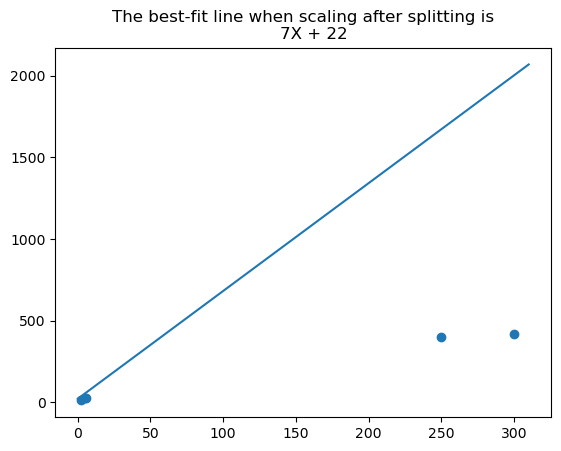

In [55]:
fig, ax = plt.subplots()

X = np.linspace(0, 310, 600)
y = lr2.coef_ * X + lr2.intercept_

ax.scatter(df['pred'], df['target'])
ax.plot(X, y)
ax.set_title(f"""The best-fit line when scaling after splitting is
    {round(lr2.coef_[0])}X + {round(lr2.intercept_)}""");